In [1]:
import numpy as np
from scipy.linalg import expm
from random import sample, shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Gamma_to_sink=5.
dL = 0.5

#System evolution
def evolve(r0, H, t):
    N_in=H.shape[0]
    
    I=np.eye(N_in, dtype="complex64")
    sm=np.zeros([N_in,N_in], dtype="complex64")
    sm[0,2]=1
    sp=np.zeros([N_in,N_in], dtype="complex64")
    sp[2, 0]=1
    
    L_uni=np.kron(I, H)-np.kron(H.transpose().conjugate(), I)
    L_sink=Gamma_to_sink*(2*np.kron(sp.transpose(), sm)-np.kron(I, sp@sm)-np.kron((sp@sm).transpose().conjugate(), I))
    return (expm((1j*L_uni+L_sink)*t)@r0).real[0]


#Chain class
class QNetwork:
    def __init__(self, J0=1., T=1., N_max=11):
        self.J=J0
        self.T=T
        self.DE=1.
        self.N_max=N_max
        
        self.nodes_coordinates=np.zeros(self.N_max)
        self.nodes_coordinates[0]=1.
        self.nodes_coordinates[-1]=1.
        self.nodes_positions=[np.array([-1.]), np.array([0.]), np.array([1.])]
   
        self.H=np.zeros([3,3], dtype="complex64")
        self.H[1,1]=self.DE
        self.H[2,2]=self.DE
        self.H[1,2]=self.J
        self.H[2,1]=self.J
        self.rho0=np.zeros([3,3])
        self.rho0[1,1]=1
        self.rho0=self.rho0.reshape(9)
    
    #Interactions
    def H_ij(self, x_i, x_j):
        return self.J/((np.linalg.norm(x_j-x_i))**3)
    
    #Add new node to the chain and update Hamiltonian and state
    def add_node(self, nx):
        self.nodes_coordinates[nx]=1.
        x=float(nx)/(self.N_max-1) + dL*np.random.random()/(self.N_max-1)
        
        id_last=self.H.shape[0]
        H_new = self.H.copy()
        H_new=np.vstack((np.hstack((H_new, np.zeros([id_last,1], complex))), np.zeros([1,id_last+1], complex)))
        for i in range(1, id_last):
            H_new[id_last,i]=self.H_ij(x, self.nodes_positions[i])
            H_new[i, id_last]=H_new[id_last,i]
        H_new[id_last, id_last]=self.DE
        
        rho0=np.zeros([id_last+1, id_last+1])
        rho0[1,1]=1
        rho0=rho0.reshape((id_last+1)**2)
        
        self.rho0=rho0
        self.nodes_positions+=[np.array(x)]
        self.H=H_new
        
    #FOR REINFORCEMENT LEARNING
    #Reset chain to the original configuration
    def reset(self):
        self.nodes_coordinates=np.zeros(self.N_max)
        self.nodes_coordinates[0]=1.
        self.nodes_coordinates[-1]=1.
        self.nodes_positions=[np.array([-1.]), np.array([0.]), np.array([1.])]
   
        self.H=np.zeros([3,3], dtype="complex64")
        self.H[1,1]=self.DE
        self.H[2,2]=self.DE
        self.H[1,2]=self.J
        self.H[2,1]=self.J
        self.rho0=np.zeros([3,3])
        self.rho0[1,1]=1
        self.rho0=self.rho0.reshape(9)
        return self.nodes_coordinates
    
    #MDP step
    def step(self, action):
        terminated=False
        if self.nodes_coordinates[action]<1:
            r0 = evolve(self.rho0, self.H, self.T)
            self.add_node(action)
            r1 = evolve(self.rho0, self.H, self.T)
            reward = r1 - r0
            if r1>0.99: terminated = True
        else:
            reward = 0.
            #terminated = True
        
        return self.nodes_coordinates, reward, terminated

In [3]:
eps=1e-10

#Physical parameters
N=21
J0=0.05
T=5.

#environment
num_obs = N
num_acts = N
max_steps_per_episode=11

#learning
gamma=0.99
lmbda = 0.95
num_agents = 100
num_epochs = 4
batchsize = 64
#cS = 0.001

clip_ratio = 0.2
kinit = tf.keras.initializers.HeUniform()
loss_function = keras.losses.Huber() #MeanSquaredError() #

lr_actor = 1e-4
optimizer_actor = keras.optimizers.Adam(learning_rate=lr_actor)

lr_critic= 1e-4
optimizer_critic = keras.optimizers.Adam(learning_rate=lr_critic)


#Actor
inputs_act = layers.Input(shape=(num_obs,))
hid_act = layers.Dense(128, activation="relu", kernel_initializer=kinit)(inputs_act)
hid_act = layers.Dense(128, activation="relu", kernel_initializer=kinit)(hid_act)
output_act = layers.Dense(num_acts, activation="softmax")(hid_act)
actor = keras.Model(inputs=inputs_act, outputs=output_act)

#Critic
inputs_crit = layers.Input(shape=(num_obs,))
hid_crit = layers.Dense(128, activation="relu", kernel_initializer=kinit)(inputs_crit)
hid_crit = layers.Dense(128, activation="relu", kernel_initializer=kinit)(hid_crit)
hid_crit = layers.Dense(128, activation="relu", kernel_initializer=kinit)(hid_crit)
output_crit = layers.Dense(1, activation="linear")(hid_crit)
critic = keras.Model(inputs=inputs_crit, outputs=output_crit)

#Initialize
opt=[]
current_max=-100

env = QNetwork(J0, T, N)

In [4]:
def preprocess(states, actions, rewards, done, values): 
    g = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * done[i] - values[i]
        g = delta + gamma * lmbda * done[i] * g
        returns.append(g + values[i])

    returns.reverse()
    adv = np.array(returns, dtype=np.float32) - values[:-1]
    return returns, adv.tolist()

def learn_epoch(states, actions, advs, old_probs, returns):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            probs = actor(states)
            values = critic(states)
            L_clip = -sum([min(advs[batch]*probs[batch][actions[batch]]/old_probs[batch][actions[batch]], tf.clip_by_value(probs[batch][actions[batch]]/old_probs[batch][actions[batch]], 1.-clip_ratio, 1.+clip_ratio)*advs[batch]) for batch in range(batchsize)])/batchsize
            L_crit = loss_function(values, returns.astype("float32"))
            #L_entropy = -sum([-tf.tensordot(probs[batch], tf.math.log(probs[batch]+eps), axes=1) for batch in range(batchsize)])/batchsize
         
                
            grads1 = tape1.gradient(L_clip, actor.trainable_variables) #+cS*L_entropy
            grads2 = tape2.gradient(L_crit, critic.trainable_variables)
        
            optimizer_actor.apply_gradients(zip(grads1, actor.trainable_variables))
            optimizer_critic.apply_gradients(zip(grads2, critic.trainable_variables))
    
    return L_clip.numpy(), L_crit.numpy(), 0#cS*L_entropy.numpy()

In [25]:
actions_history = []
states_history = []
advs_history = []
returns_history = []
probs_history = []

test_performance = []

num_episodes = 3000
episode_count = 0

while True:
    opt_rew=-100
    performance_episode = 0
    for agent in range(num_agents):
        actions_agent = []
        states_agent = []
        values_agent = []
        done_agent = []
        rewards_agent = []
        probs_agent = []
        
        state=env.reset()
        for timestep in range(1, max_steps_per_episode):
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = actor(state_tensor, training=False)
            critic_values = critic(state_tensor, training=False)
            action = np.random.choice(num_acts, p=np.squeeze(action_probs))
            
            state_next, reward, done = env.step(action)
            state_next = np.array(state_next, dtype=np.float32)
            
            probs_agent.append(np.squeeze(action_probs))
            actions_agent.append(action)
            states_agent.append(state)
            values_agent.append(critic_values.numpy()[0][0])
            done_agent.append(1-done)
            rewards_agent.append(reward)
            state = state_next
            
            performance_episode+=reward
            if reward>opt_rew: opt_rew=reward
            
            if done:
                break
                
        final_pops = evolve(env.rho0, env.H, env.T)
        if final_pops > current_max:
            current_max = final_pops
            opt = env.nodes_coordinates
                
        values_agent.append(0.)
            
        returns_agent, advs_agent = preprocess(states_agent, actions_agent, rewards_agent, done_agent, values_agent)
        
        actions_history += actions_agent
        states_history += states_agent
        returns_history += returns_agent
        advs_history += advs_agent
        probs_history += probs_agent
        
    #advs_history = ((np.array(advs_history) - np.array(advs_history).mean())/np.array(advs_history).std()).tolist()
    test_performance += [performance_episode/(num_agents)]
    
    lossA = 0
    lossC = 0
    lossS = 0
    for epoch in range(num_epochs):
        indices = np.random.choice(range(len(returns_history)), size=batchsize)
        states_sample = np.array([states_history[i] for i in indices])
        actions_sample = np.array([actions_history[i] for i in indices])
        probs_sample = np.array([probs_history[i] for i in indices])
        returns_sample = np.array([returns_history[i] for i in indices])
        advs_sample = np.array([advs_history[i] for i in indices])
        lossA_epoch, lossC_epoch, lossS_epoch = learn_epoch(states_sample, actions_sample, advs_sample, probs_sample, returns_sample)
        lossA += lossA_epoch/num_epochs
        lossC += lossC_epoch/num_epochs
        lossS += lossS_epoch/num_epochs
    
    max_prob = probs_history[0].max()
    
    actions_history.clear()
    states_history.clear()
    returns_history.clear()
    advs_history.clear()
    probs_history.clear()
    
    state=env.reset()
    for timestep in range(1, max_steps_per_episode):
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = actor(state_tensor, training=False)
        critic_values = critic(state_tensor, training=False)
        action = np.argmax(np.squeeze(action_probs))
        state_next, reward, done = env.step(action)
        state_next = np.array(state_next, dtype=np.float32)
        state=state_next
        if done: break    
    final_pops = evolve(env.rho0, env.H, env.T)
    
    print(episode_count, current_max, final_pops, opt_rew, max_prob, lossC, test_performance[-1])
    
    episode_count+= 1   
    if episode_count>num_episodes:
        break

0 0.36951673399506757 1.9810345621069923e-05 0.8850769539655866 0.07945363 0.1729537397623062 0.010187781285788617
1 0.5717062484426515 2.5045766901791937e-05 0.9227576059184471 0.079352684 0.106514111161232 0.00648533971458477
2 0.9984635198051502 1.607330802197699e-05 0.9420845623500562 0.07963427 0.0701904371380806 0.022557575633216382
3 0.9984635198051502 5.82595602503607e-05 0.9411549408467826 0.08008714 0.07210766710340977 0.015197783657896802
4 0.9984635198051502 9.318861195270078e-06 0.8078351548197856 0.08012303 0.05823308229446411 0.006739128832086632
5 0.9984635198051502 3.29200945148739e-05 0.9301252597370513 0.080299206 0.05280151590704918 0.007982942160738075
6 0.9984635198051502 4.790780894459793e-05 0.9363904644947787 0.080412105 0.06382563803344965 0.004417545992190128
7 0.9984635198051502 8.694226676199691e-07 0.9015362933743196 0.08026904 0.0618200097233057 0.003767827475699162
8 0.9984635198051502 1.3899369999467307e-06 0.9761397592206792 0.08016441 0.04513503890484

71 0.9996386243558734 0.003424319349359512 0.8618451298858961 0.07316901 0.01328281918540597 0.0033640091129860544
72 0.9996386243558734 0.0032786889732438883 0.8383359293986782 0.073290914 0.011398048372939229 0.018243581667108943
73 0.9996386243558734 0.0026305706445599875 0.9282134070706025 0.07366027 0.016046489821746945 0.024078261743230783
74 0.9996386243558734 0.002897622901756602 0.9599388915226746 0.074191645 0.01695180730894208 0.0026292340902907964
75 0.9996386243558734 0.0026739834729638664 0.9267681828582974 0.0746905 0.012464955914765596 0.008253396395239272
76 0.9996386243558734 0.0038174598938666986 0.9239310190388427 0.07527934 0.011231327895075083 0.009073707849909617
77 0.9996386243558734 0.0033494763225211813 0.7880364382342544 0.07572057 0.01274100923910737 0.0027301162312452576
78 0.9996386243558734 0.0036772632887853715 0.8575336275634983 0.07590244 0.01607852801680565 0.025303593109860776
79 0.9996386243558734 0.0034486623102577343 0.860399540037033 0.07596699 0

143 0.9998630258763246 0.0038751447120065857 0.9826513020706565 0.08024877 0.014883769676089287 0.05090544545585527
144 0.9998630258763246 0.0023810131646432235 0.9042593687217875 0.0803913 0.01986117660999298 0.03813716308050533
145 0.9998630258763246 0.003107013328044389 0.9745431567867692 0.08052478 0.01343835098668933 0.019987733299898825
146 0.9998630258763246 0.002992562413429302 0.9636306188517924 0.08081407 0.011091551627032459 0.022301136780403765
147 0.9998630258763246 0.0032454558150308717 0.9773260300382216 0.081119455 0.014861574629321694 0.009946628115527855
148 0.9998630258763246 0.0037050134985018215 0.9485005260199798 0.08101726 0.0097712924471125 0.014942134416759068
149 0.9998630258763246 0.002705941612521937 0.9365673622259145 0.08073112 0.011728470679372549 0.03514190946099634
150 0.9998630258763246 0.003746438729585006 0.9415696584843117 0.08079025 0.011422656010836363 0.022318326146786208
151 0.9998630258763246 0.003269431168360112 0.79596946423193 0.080730446 0.

214 0.9998630258763246 0.0020656204363867247 0.8951719454620797 0.085535645 0.00949924427550286 0.021616206803469915
215 0.9998630258763246 0.0029284099910052404 0.9350904404960962 0.08611875 0.02122059720568359 0.04555016507163424
216 0.9998630258763246 0.0035958085623844604 0.8716353827005482 0.08691898 0.00967580231372267 0.023680811749459473
217 0.9998630258763246 0.003216355824793213 0.9837482790352972 0.08780049 0.010904736118391156 0.023303495279168814
218 0.9998630258763246 0.003687480917678446 0.9904841441424932 0.088830605 0.00962453312240541 0.027146768751329556
219 0.9998630258763246 0.0024351491183941237 0.907375833665196 0.08930271 0.009679358860012144 0.02476250754763544
220 0.9998630258763246 0.003909510729901942 0.9227959731994596 0.089720525 0.014506061794236302 0.016516994969445333
221 0.9998630258763246 0.0025915931672729417 0.9187148140287745 0.08994144 0.005844471277669072 0.025541926974185235
222 0.9998630258763246 0.003783565562976163 0.8727823311644806 0.089601

286 0.9998630258763246 0.007915205605913514 0.8879391126542374 0.09590033 0.013090393389575183 0.02467147779933621
287 0.9998630258763246 9.701388560480728e-05 0.9137609048590841 0.09653309 0.014007706544362009 0.03707710279209419
288 0.9998630258763246 0.0005979864202469809 0.8366671096413942 0.09671207 0.013414222514256835 0.041150960338683075
289 0.9998630258763246 0.011922217080698084 0.9786213065268157 0.09678823 0.016311747021973133 0.04012014706756974
290 0.9998630258763246 0.016930379709280696 0.9362270112647622 0.09692428 0.013214282458648086 0.043845203419515845
291 0.9998630258763246 0.00016904872162062004 0.9372428702166724 0.09784226 0.012957931612618268 0.04245213178304818
292 0.9998630258763246 0.0005523569893549206 0.9961138522957216 0.09872297 0.02614003326743841 0.03287504923233628
293 0.9998630258763246 0.004847064501975173 0.9323341543915484 0.09920497 0.015116890193894506 0.060593789647887156
294 0.9998630258763246 0.004583954692395147 0.8926034573101151 0.09948825

358 0.9998733989583134 0.32068621552248133 0.8918191790918968 0.11583823 0.011777460109442472 0.043203484472282325
359 0.9998733989583134 0.3147226308418976 0.9024546106432664 0.116644725 0.016411329619586468 0.04920635495915399
360 0.9998733989583134 0.16019181568053137 0.8923343039591162 0.117011204 0.02263344544917345 0.04477426783578097
361 0.9998733989583134 0.30090240959718495 0.9377698581329019 0.11775731 0.02107802382670343 0.03473698502730477
362 0.9998733989583134 0.3406054903456411 0.9116072682178804 0.11866207 0.01464370102621615 0.05886633171095457
363 0.9998733989583134 0.19246811497727861 0.9194571538520941 0.11935259 0.018160186242312193 0.05337278728864342
364 0.9998733989583134 0.10500110491212877 0.9370154569046888 0.12013796 0.021671175956726074 0.059506947219241504
365 0.9998733989583134 0.1686154649392744 0.9621253357383625 0.12095224 0.029086859431117773 0.09679697151364479
366 0.9998733989583134 0.2305404357197994 0.9247693428661495 0.12172217 0.0223075596150010

431 0.9998864128365038 0.33242319096628087 0.9454158355456841 0.16609429 0.038378965109586716 0.12971559944418212
432 0.9998864128365038 0.23226725400668713 0.9164682756566583 0.16894595 0.0100076321978122 0.06930692879117138
433 0.9998864128365038 0.27393248358542066 0.9143271798288317 0.1700406 0.029039955232292414 0.086078997036062
434 0.9998864128365038 0.32061811172637034 0.9839082619727844 0.17282882 0.011758327018469572 0.08271249081571388
435 0.9998864128365038 0.3223522012271167 0.8994480933421496 0.17468937 0.03479159204289317 0.14860467489963108
436 0.9998864128365038 0.40628765710848375 0.9296974642395845 0.17613317 0.030665626749396324 0.14773021409574413
437 0.9998864128365038 0.3493067615495854 0.9849580927674516 0.17688003 0.033792286179959774 0.15554589304947575
438 0.9998864128365038 0.23052217156566027 0.9731814157861329 0.17574418 0.028935851994901896 0.11526131712947764
439 0.9998864128365038 0.3336947133578292 0.9303429808033331 0.17723298 0.02026613662019372 0.09

505 0.9998864128365038 0.9843825500933036 0.9166599018140804 0.39511862 0.09122263267636299 0.7083899104606965
506 0.9998864128365038 0.9883900856981785 0.9813624969128649 0.3974309 0.08645826391875744 0.7521393635493232
507 0.9998864128365038 0.9698339947546685 0.9175736344717601 0.39861035 0.07452068105340004 0.6849579238686823
508 0.9998864128365038 0.9937852970721918 0.9374143571891036 0.4038017 0.09904275089502335 0.7599897210600891
509 0.9998864128365038 0.9900404263745607 0.9055606533152111 0.40922856 0.08336483128368855 0.7864171246547406
510 0.9998864128365038 0.9954224616366758 0.9261158971119654 0.41110903 0.079323660582304 0.7525414529975563
511 0.9998864128365038 0.9912115173148086 0.9090803505063301 0.41015372 0.0878037828952074 0.7634496296399143
512 0.9998864128365038 0.9921910733667608 0.9174900964248958 0.41146433 0.09059980697929859 0.8062688691771908
513 0.9998864128365038 0.9722050553461269 0.939104140099616 0.4093462 0.07631699182093143 0.7569063264162316
514 0.99

580 0.9998864128365038 0.9972267178537096 0.9250666946288147 0.3714013 0.08365962095558643 0.9261758886416619
581 0.9998864128365038 0.9958180762324267 0.920307643854726 0.37228882 0.09055665507912636 0.9210892873231973
582 0.9998864128365038 0.9949565412065761 0.9246795865077047 0.37582523 0.0959828719496727 0.9160216417136471
583 0.9998864128365038 0.9907113489588689 0.9177301631594016 0.3811453 0.09167559817433357 0.9468785427967045
584 0.9998864128365038 0.9962806697131643 0.9005530139776867 0.39079788 0.0935630314052105 0.9295795986998047
585 0.9998864128365038 0.9886634393159426 0.9351023528879608 0.39715832 0.08751312270760536 0.9208228882564156
586 0.9998864128365038 0.9774917260825255 0.922414076387645 0.39309528 0.08622716180980206 0.9271193954271291
587 0.9998864128365038 0.9995010224690487 0.9271438067313338 0.38731802 0.085383340716362 0.9006667822357859
588 0.9998864128365038 0.9950268765052814 0.9177049391183376 0.38135877 0.09170347452163696 0.930218040527135
589 0.9998

655 0.9998864128365038 0.9902753388094729 0.9116891485511737 0.39445886 0.0950309969484806 0.9259986459466545
656 0.9998864128365038 0.9899977392892406 0.9223479533447653 0.3914992 0.09016078338027 0.9323293754874061
657 0.9998864128365038 0.9966949092913076 0.9278154081082224 0.38781503 0.09003978595137596 0.9486478233097487
658 0.9998864128365038 0.9857763695376974 0.9273905650730087 0.38475627 0.0914992056787014 0.9263696034123271
659 0.9998864128365038 0.9940546177313824 0.9215869453228407 0.38476253 0.10332327894866467 0.9254323973683835
660 0.9998864128365038 0.987168838693633 0.9184409602059223 0.38665438 0.09359284862875938 0.9739061099088258
661 0.9998864128365038 0.9961841789740249 0.9171227982358698 0.38521025 0.08978238515555859 0.9403672727589584
662 0.9998864128365038 0.9798097307431882 0.9241792074260045 0.37879735 0.0933297798037529 0.9535426738910896
663 0.9998864128365038 0.9920449070852079 0.9164053563592571 0.37051803 0.09477712027728558 0.9373092853113679
664 0.999

730 0.9998864128365038 0.9760083959061352 0.9170344577318889 0.37326416 0.09654876589775085 0.937298518130967
731 0.9998864128365038 0.9747164037611646 0.9239374419061416 0.374119 0.09819507226347923 0.9256383063202839
732 0.9998864128365038 0.9988484584016877 0.9265910657149413 0.3699074 0.09978599101305008 0.9570625592629951
733 0.9998864128365038 0.9956634642582193 0.9260494238562502 0.36579773 0.09058690629899502 0.9197728925839782
734 0.9998864128365038 0.9969983093184012 0.9251958409682771 0.36415938 0.09273425489664078 0.9706753062464574
735 0.9998864128365038 0.983296630552127 0.9197127237439313 0.3625511 0.0907547902315855 0.9743526230365791
736 0.9998864128365038 0.9933915318858779 0.9228766886213041 0.36550105 0.08831946551799774 0.95593294287665
737 0.9998864128365038 0.983590551416196 0.9206131793033938 0.36836243 0.09943201951682568 0.9443919650184615
738 0.9998864128365038 0.9793437971280444 0.9267654331189585 0.3776587 0.09813292324542999 0.968759160070868
739 0.9998864

805 0.9998864128365038 0.9756286995927996 0.9158957855960539 0.4310987 0.09046103991568089 0.9611934021143536
806 0.9998864128365038 0.9990429864772922 0.9088578440647519 0.42780203 0.08822586946189404 0.9836884775247802
807 0.9998864128365038 0.9990818757495549 0.9166863404586648 0.43144307 0.09145676717162132 0.9712870441093457
808 0.9998864128365038 0.9799980903293468 0.9206219060658744 0.43971157 0.08988199010491371 0.9570365376620201
809 0.9998864128365038 0.9761368839876113 0.9124664618483385 0.45102435 0.08698146045207977 0.9520809400164327
810 0.9998864128365038 0.9779639321042655 0.9139755251176971 0.4619399 0.08505052700638771 0.9530592188965941
811 0.9998864128365038 0.98816257689802 0.9250658373724345 0.4625465 0.09053556434810162 0.9751755007645088
812 0.9998864128365038 0.992922471153922 0.9187740973034623 0.4585881 0.08689581230282784 0.9670749956391272
813 0.9998864128365038 0.975661634636712 0.9109059222101551 0.45575592 0.07503452152013779 0.9332909877271465
814 0.999

KeyboardInterrupt: 

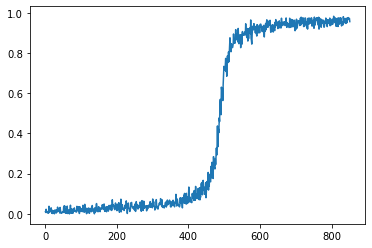

In [26]:
plt.plot(test_performance)

In [33]:
Ntests = 5000
final_pops = 0.
for n in range(Ntests):
    state=env.reset()
    for timestep in range(1, max_steps_per_episode):
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = actor(state_tensor, training=False)
        critic_values = critic(state_tensor, training=False)
        action = np.argmax(np.squeeze(action_probs))
        state_next, reward, done = env.step(action)
        state_next = np.array(state_next, dtype=np.float32)
        state=state_next
        if done: break    
    final_pops += evolve(env.rho0, env.H, env.T)
print(final_pops/float(Ntests))

0.9884538507265952


In [28]:
print(state)

[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]


In [29]:
np.savetxt("PPOchain_grid21_disordered50_J_0_05_learning.csv", np.array(test_performance), delimiter=",")

In [30]:
actor.save("PPOchain_grid21_disordered50_J_0_05_actor")
critic.save("PPOchain_grid21_disordered50_J_0_05_critic")

INFO:tensorflow:Assets written to: PPOchain_grid21_disordered50_J_0_05_actor\assets
INFO:tensorflow:Assets written to: PPOchain_grid21_disordered50_J_0_05_critic\assets
